# Tutorial: data integration for PBMC data (10x Genomics Visium)

In this tutorial, we demonstrate how to apply FGOT to integrate paired PBMC data. The dataset is publicly assessible (https://). 

## loading package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
import sys
sys.path.insert(1, '/home/nas2/biod/yangchenghui/FGOT-master')
import FGOT
from FGOT import preprocess as pre
from FGOT import fgot_sparse_4dim, fgot_tol, align
from FGOT import metrics as mt

## loading data

In [19]:
data_path = "/home/nas2/biod/yangchenghui/FGOT-master/data/PBMC_data/"
RNA_data = pd.read_csv(data_path+'feature_selected_RNA_normalized.txt', sep='\t', index_col=0)
ATAC_data = pd.read_csv(data_path+'feature_250kb_ATAC_normalized.txt', sep='\t', index_col=0)

cell1_cluster = pd.read_csv(data_path+'label.txt', sep='\t').rename(columns={'Unnamed: 0': 'cell', 'metas': 'cluster'})
cell2_cluster = cell1_cluster.copy()

In [4]:
X1 = RNA_data.T
X2 = ATAC_data.T
(n1, d1) = X1.shape
(n2, d2) = X2.shape
print("Dimensions of input datasets are: ", "X1 = ", X1.shape, " X2 = ", X2.shape)
basic_labels1 = np.array(cell1_cluster['cluster'])
basic_labels2 = np.array(cell2_cluster['cluster'])
print("Dimensions of basic_labels are: ", "basic_labels1 = ", basic_labels1.shape, " basic_labels2 = ", basic_labels2.shape)
cell_names1 = list(RNA_data.columns)
cell_names2 = list(ATAC_data.columns)
gene_names = list(RNA_data.index)
peak_names = list(ATAC_data.index)

Dimensions of input datasets are:  X1 =  (3197, 215)  X2 =  (3197, 7835)
Dimensions of basic_labels are:  basic_labels1 =  (3197,)  basic_labels2 =  (3197,)


## compute feature relationship

In [5]:
promoters = pd.read_csv(data_path+'hg38.promoter.regions.txt', sep = '\t')
promoters.head()

,chr,starts,ends,genes
1,chr1,12623,12624.0,DDX11L1
2,chr1,30120,30121.0,WASH7P
3,chr1,18186,18187.0,MIR6859.1
4,chr1,18186,18187.0,MIR6859.2
5,chr1,18186,18187.0,MIR6859.3


In [13]:
feature_matrix = pre.prior_feature_graph(promoters, gene_names, peak_names)
feature_matrix

72337it [00:00, 244084.49it/s]
41399it [00:00, 52429.37it/s]
100%|██████████| 215/215 [00:00<00:00, 287.07it/s]


The number of gene nodes, peak nodes, and edges in the prior feature graph is: 215 7835 9115


100%|██████████| 9115/9115 [00:00<00:00, 1705526.45it/s]


,chr17-48456637-48457880,chr16-3011951-3014525,chr19-54434338-54435688,chr19-35484675-35485088,chr1-160284015-160285824,chr10-71864777-71866152,chr20-50376755-50377346,chr10-113267586-113268550,chr19-18019781-18024955,chr2-84819180-84820065,...,chr12-44842620-44843963,chr17-48460117-48460318,chr19-669202-669513,chr2-8486084-8486600,chr10-72073176-72077989,chr19-18414123-18442655,chr12-31705380-31706105,chr18-55778545-55781183,chr10-70363713-70365125,chr2-95073812-95075834
NIPAL3,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
RCAN3AS,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
RCAN3,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
HYI,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
CD52,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCF4,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,1.0,inf,inf
BCL2,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
LINC01478,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
SETBP1,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


## compute cost

We use wnn to calculate cost.

In [15]:
wnn = pd.read_csv(data_path+'PBMC_wnn.txt', sep='\t', index_col=0)
wnn

,Agg_1,Agg_2,Agg_3,Agg_4,Agg_5,Agg_6,Agg_7,Agg_8,Agg_9,Agg_10,...,Agg_3192,Agg_3193,Agg_3194,Agg_3195,Agg_3196,Agg_3197,Agg_3198,Agg_3199,Agg_3200,Agg_3201
Agg_1,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Agg_2,0.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Agg_3,0.0,0.0,1.000000,0.176471,0.0,0.0,0.000000,0.000000,0.081081,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Agg_4,0.0,0.0,0.176471,1.000000,0.0,0.0,0.000000,0.000000,0.379310,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Agg_5,0.0,0.0,0.000000,0.000000,1.0,0.0,0.111111,0.176471,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Agg_3197,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.538462,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.212121,0.000000
Agg_3198,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.176471,0.081081,0.212121,0.000000,1.000000,0.379310,0.000000,0.176471
Agg_3199,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.250000,0.000000,0.428571,0.142857,0.538462,0.000000,0.379310,1.000000,0.000000,0.481481
Agg_3200,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.176471,0.142857,0.000000,0.250000,0.000000,0.212121,0.000000,0.000000,1.000000,0.000000


In [16]:
cost = np.array(np.exp(1 - wnn))
cost = cost - np.min(cost)
cost = pd.DataFrame(cost, index = cell_names1, columns=cell_names2)

Text(0.5, 1.0, 'cost across modality')

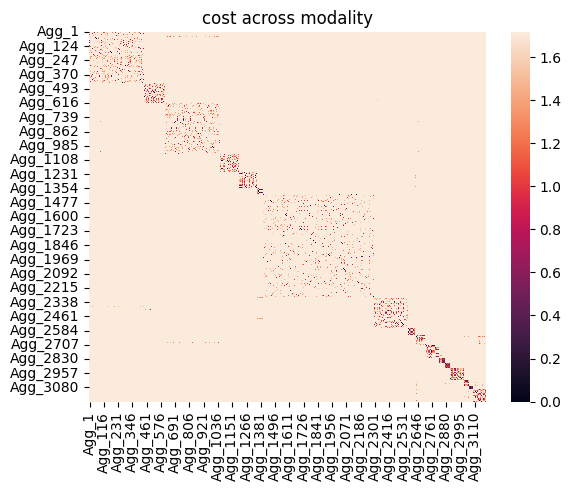

In [17]:
sns.heatmap(cost)
pl.title('cost across modality')

## scale

In [8]:
scaler = StandardScaler()
X1, X2 = scaler.fit_transform(X1), scaler.fit_transform(X2)
X1 = pd.DataFrame(X1,index= cell_names1,columns=gene_names)
X2 = pd.DataFrame(X2,index= cell_names2,columns=peak_names)

## solve the feature-guided optimal transport

In [ ]:
P_4dim = fgot_sparse_4dim(X1, X2, feature_matrix, cost, cell1_cluster,cell2_cluster,\
    minibatch=1, batchsize=100, pair = True, device='cuda:6', eps_p = 1e-1, rho=10)

In [12]:
P = fgot_tol(P_4dim)
P.shape

100%|██████████| 9115/9115 [05:00<00:00, 30.35it/s]


(3197, 3197)

Text(0.5, 1.0, 'optimal transport matrix')

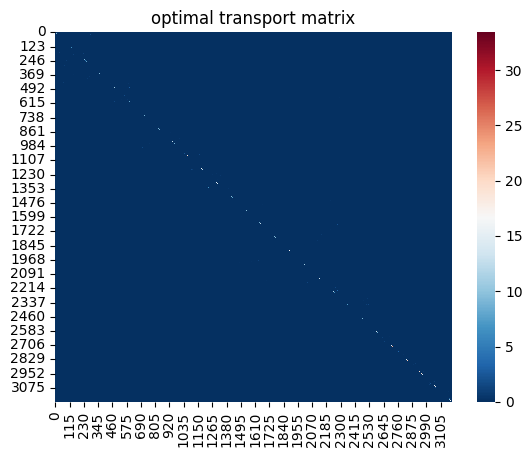

In [13]:
sns.heatmap(P, cmap="RdBu_r")
pl.title('optimal transport matrix')

In [15]:
X1_aligned, X2_aligned = align(X1, X2, P)

  0%|          | 0/31 [17:56<?, ?it/s]
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-p

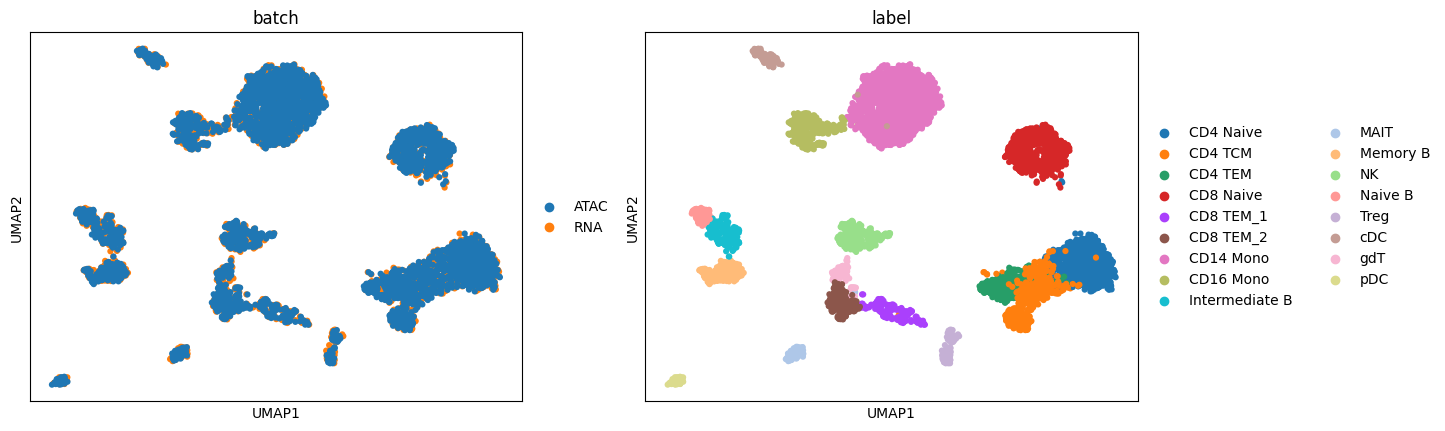

In [16]:
data_aligned = np.concatenate((X1_aligned,X2_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['RNA'] * n1 + ['ATAC'] * n2)
adata_aligned.obs['label'] = np.concatenate((basic_labels1, basic_labels2),axis=0)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)
sc.pl.umap(adata_aligned, color=['batch', 'label'],s = 80)

## Calculate the intensity of regulation by optimal transport tensor

In [21]:
from scipy.sparse import coo_matrix
def regulation_score(P_4dim,cluster,cell1_cluster,cell2_cluster):
    shape = P_4dim.get(list(P_4dim.keys())[0]).shape
    n1, n2 = shape[0],shape[1]
    Ix = np.zeros(n1)
    Iy = np.zeros(n2)
    indices1 = cell1_cluster.index[cell1_cluster['cluster'] == cluster].tolist()
    indices2 = cell2_cluster.index[cell2_cluster['cluster'] == cluster].tolist()
    Ix[indices1] = 1
    Iy[indices2] = 1
    nx = np.sum(Ix)
    ny = np.sum(Iy)
    Ix = coo_matrix(Ix)
    Iy = coo_matrix(Iy).transpose()
    pair_names = []
    score = []
    total = 0
    for (i,j) in P_4dim.keys():
        S = P_4dim[(i,j)]
        tmp = (Ix.dot(S)).dot(Iy).data
        if len(tmp) == 0:
            tmp = 0
        else:
            tmp = tmp[0]/(nx*ny)
        score.append(tmp)
        pair_names.append("%s-%s" % (i, j))
        total += tmp
    score.append(total)
    pair_names.append("total")
    score = np.array(score)
    score = score.reshape(1, -1)
    score = pd.DataFrame(data=score, columns=pair_names, index=[cluster])
    return score 

In [25]:
CD8_score = regulation_score(P_4dim,"CD8 Naive",cell1_cluster,cell2_cluster)
CD4_score = regulation_score(P_4dim,"CD4 Naive",cell1_cluster,cell2_cluster)
Naive_B = regulation_score(P_4dim,"Naive B",cell1_cluster,cell2_cluster)

In [40]:
df_combined = pd.concat([CD8_score, CD4_score, Naive_B])
df_combined

,NIPAL3-chr1-24526978-24527587,NIPAL3-chr1-24555461-24556904,NIPAL3-chr1-24540146-24542365,NIPAL3-chr1-24186819-24188292,NIPAL3-chr1-24320455-24320490,NIPAL3-chr1-24174017-24174414,NIPAL3-chr1-24586818-24587824,NIPAL3-chr1-24475562-24476166,NIPAL3-chr1-24199179-24199973,NIPAL3-chr1-24557600-24558257,...,TTC39C-chr18-23969995-23971327,TTC39C-chr18-23864452-23865330,TTC39C-chr18-24076053-24076699,TTC39C-chr18-23992116-23993430,TTC39C-chr18-23825911-23826319,TTC39C-chr18-23994161-23995006,TTC39C-chr18-23942896-23943589,TTC39C-chr18-23998926-24002963,TTC39C-chr18-24115568-24116036,total
CD8 Naive,0.000011,0.000013,0.000009,0.000010,0.000005,0.000000e+00,0.000014,0.000014,0.000011,0.000005,...,0.000004,0.000003,0.000002,5.439080e-06,0.000001,0.000002,0.000004,0.000001,0.000003,0.025788
CD4 Naive,0.000007,0.000009,0.000009,0.000006,0.000002,9.391903e-08,0.000011,0.000018,0.000009,0.000004,...,0.000006,0.000005,0.000004,7.508248e-06,0.000002,0.000003,0.000008,0.000002,0.000003,0.021263
Naive B,0.000044,0.000028,0.000042,0.000038,0.000000,1.528782e-05,0.000038,0.000007,0.000070,0.000045,...,0.000030,0.000011,0.000015,3.652374e-07,0.000014,0.000010,0.000000,0.000002,0.000008,0.445537
